In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 2nd Order Runge-Kutta / Midpoint Method

We'll continue to work on the orbit problem.  To make life easier, the `OrbitState` and `rhs` functions are now in a module, along with a function `initial_conditions` that provides the inital state, `plot` that makes a plot of the orbit, and `error` that computes the error.  We can simply import from `orbit_util.py` to access these.

In [2]:
import orbit_util as ou

The Euler method was based on a first-order difference approximation to the derivative.  But we know that a centered-derivative is second order accurate, so we can try to update our system in the form:

$$\frac{{\bf r}^{n+1} - {\bf r}^n}{\tau} = {\bf v}^{n+1/2} + \mathcal{O}(\tau^2)$$

$$\frac{{\bf v}^{n+1} - {\bf v}^n}{\tau} = {\bf a}^{n+1/2} + \mathcal{O}(\tau^2)$$

Then the updates are:

$${\bf r}^{n+1} = {\bf r}^n + \tau \, {\bf v}^{n+1/2} + \mathcal{O}(\tau^3)$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}^{n+1/2} + \mathcal{O}(\tau^3)$$

This is locally third-order accurate (but globally second-order accurate), but we don't know how to compute the state at the half-time.

To find the $n+1/2$ state, we first use Euler's method to predict the state at the midpoint in time.  We then use this provisional state to evaluate the accelerations at the midpoint and use those to update the state fully through $\tau$.  

The two step process appears as:

$${\bf r}^\star = {\bf r}^n + (\tau / 2) {\bf v}^n$$

$${\bf v}^\star = {\bf v}^n + (\tau / 2) {\bf a}^n$$

then we use this for the full update:

$${\bf r}^{n+1} = {\bf r}^n + \tau \,  {\bf v}^\star$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}({\bf r}^\star)$$

Graphically this looks like the following:

First we take a half step and we evaluate the slope at the midpoint:

![RK2 half step](rk2_halfEuler.png)

Then we go back to $t^n$ but follow the slope we found above all the way to $t^{n+1}$:

![RK2 final](rk2_final.png)

Notice how the final step (the red line) is parallel to the slope we computed at $t^{n+1/2}$.  Also note that the solution at $t^{n+1}$ is much closer to the analytic solution than in the figure from Euler's method.

Let's see how this method does with the orbit problem.

In [3]:
def euler_rk2(state0, tau, T):

    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        ydot = ou.rhs(state_old)
    
        # predict the state at the midpoint
        state_tmp = state_old + 0.5 * tau * ydot
        
        # evaluate the RHS at the midpoint
        ydot = ou.rhs(state_tmp)
        
        # do the final update
        state_new = state_old + tau * ydot
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

Integrate our orbit.

In [4]:
T = 1
tau = T/12.0

state0 = ou.initial_conditions()

times, history = euler_rk2(state0, tau, 1)

Let's plot our orbit

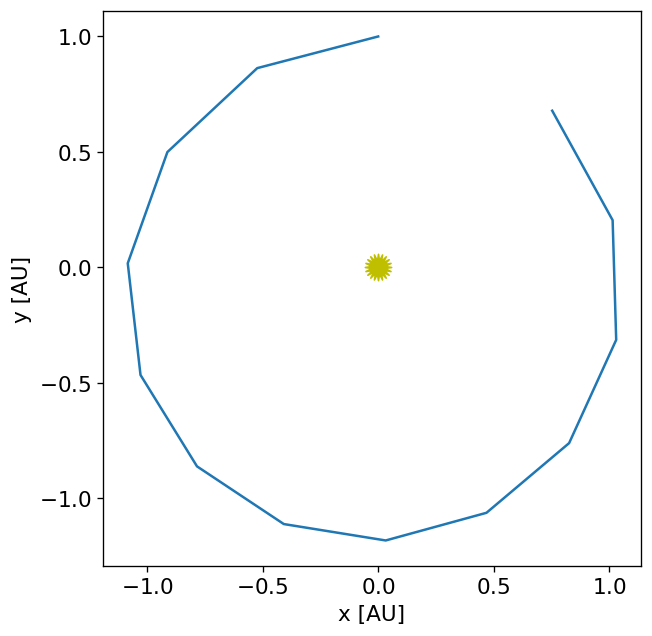

In [5]:
fig = ou.plot(history)

This is substantially better than the first-order Euler method.  Now let's look at a range of timesteps.

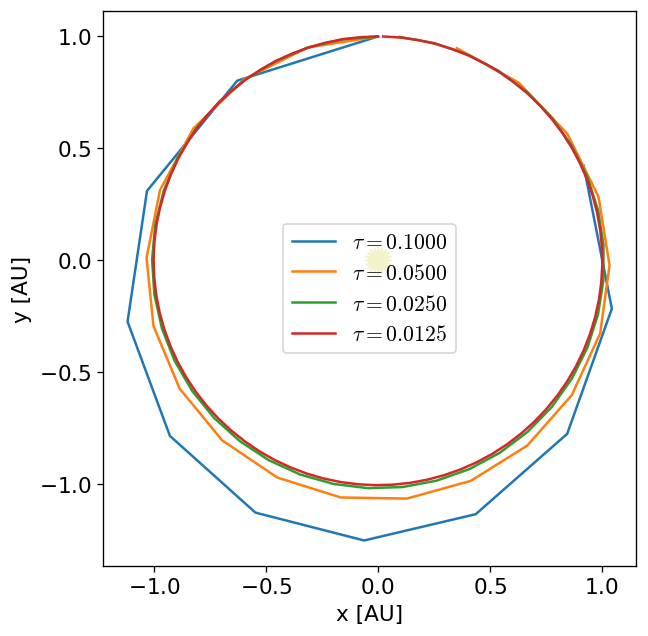

In [6]:
taus = [0.1, 0.05, 0.025, 0.0125]

for n, tau in enumerate(taus):
    times, history = euler_rk2(state0, tau, 1)
    
    if n == 0:
        fig = ou.plot(history, label=rf"$\tau = {tau:6.4f}$")
    else:
        ou.plot(history, ax=fig.gca(), label=rf"$\tau = {tau:6.4f}$")
        
fig.gca().legend()

and how does the error converge?

In [8]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
    times, history = euler_rk2(state0, tau, 1)
    print(f"{tau:8} : {ou.error_radius(history):10.5g} {ou.error_position(history):10.5g}")

     0.1 :     0.0116     1.0856
    0.05 :   0.011123    0.35694
   0.025 :  0.0024709   0.096669
  0.0125 : 0.00036069   0.023906
 0.00625 : 4.6926e-05  0.0058463


Notice that once we get past the first, very coarse $\tau$, the errors seem to decrease by a factor of 4 when we halve the timestep&mdash;as we'd expect for a 2nd order accurate method. (Actually, it looks like the measure of radius converges better than position).